In [4]:
##Import the libraries
# Warnings
import warnings
warnings.filterwarnings('ignore')
## math library for mathematical function
import math
## labeled data view in dataframe
import pandas as pd
## data reader od panda is used fetch the data from web
import pandas_datareader as web
## numpy is used to create multi dimensional array
import numpy as np
## tensorflow is uded to create DL model and wrapping the other libraries
import tensorflow as tf
## sklearn is providing ultility functions for standerdizing or scaling data
from sklearn.preprocessing import MinMaxScaler
## keras is a neural network library
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
## it is uded to create plotting area
import matplotlib.pyplot as mtlplt
## feature scaling distribution
from matplotlib import rcParams
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# ========= Models & Training (with TimeSeries CV & optional XGBoost) =========
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


In [5]:
data_frame = pd.read_csv("electricityConsumptionAndProductioction1.csv")
data_frame.head(10)

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
5,2019-01-01 05:00:00,5525,5385,1395,91,958,1455,1456,0,30
6,2019-01-01 06:00:00,5513,5349,1392,98,938,1451,1440,0,31
7,2019-01-01 07:00:00,5524,5547,1392,93,1187,1446,1394,0,34
8,2019-01-01 08:00:00,5510,5471,1391,51,1325,1357,1303,8,34
9,2019-01-01 09:00:00,5617,5545,1388,15,1398,1328,1319,61,34


In [6]:
# Convert "DateTime" to datetime format and split into "Date" and "Time" columns
dt = pd.to_datetime(data_frame["DateTime"], errors="coerce")  # don't overwrite the DataFrame
data_frame.insert(data_frame.columns.get_loc("DateTime") + 1, "Time", dt.dt.strftime("%H:%M:%S"))
data_frame["DateTime"] = dt.dt.strftime("%Y-%m-%d")  # or: dt.dt.date
data_frame.head(10) 

,DateTime,Time,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01,00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01,01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01,02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01,03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01,04:00:00,5557,5454,1393,159,960,1454,1458,0,30
5,2019-01-01,05:00:00,5525,5385,1395,91,958,1455,1456,0,30
6,2019-01-01,06:00:00,5513,5349,1392,98,938,1451,1440,0,31
7,2019-01-01,07:00:00,5524,5547,1392,93,1187,1446,1394,0,34
8,2019-01-01,08:00:00,5510,5471,1391,51,1325,1357,1303,8,34
9,2019-01-01,09:00:00,5617,5545,1388,15,1398,1328,1319,61,34


In [7]:
# Check the number of NaT values in DateTime
data_frame[data_frame["DateTime"].isna()]


,DateTime,Time,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass


In [8]:
# Count the number of missing (null or NaN) values in each column of a DataFrame
data_frame.isnull().sum()

DateTime         0
Time             0
Consumption      0
Production       0
Nuclear          0
Wind             0
Hydroelectric    0
Oil and Gas      0
Coal             0
Solar            0
Biomass          0
dtype: int64

In [9]:
# Check the number of NaT values in DateTime
data_frame[data_frame["DateTime"].isna()]

,DateTime,Time,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass


In [10]:
# Group by daily data
#daily_df = data_frame.groupby('DateTime').sum(numeric_only = True).reset_index()

daily_df = (
    data_frame
    .groupby("DateTime", as_index=False)
    .agg({
        "Consumption": "sum",
        "Production": "sum",
        "Nuclear": "sum",
        "Wind": "sum",
        "Hydroelectric": "sum",
        "Oil and Gas": "sum",
        "Coal": "sum",
        "Solar": "sum",
        "Biomass": "sum"
    })
)
daily_df


,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01,142984,142186,33402,8246,30861,34032,33809,1039,787
1,2019-01-02,151729,163097,33380,26562,30065,38764,32175,1280,858
2,2019-01-03,174098,172854,32929,23743,35453,43732,35225,800,956
3,2019-01-04,183242,191724,32914,44510,33884,41808,36469,1092,1038
4,2019-01-05,177114,164069,33440,15108,29089,44158,39031,2226,1008
...,...,...,...,...,...,...,...,...,...,...
2263,2025-03-15,139200,142058,32951,28068,30755,26008,18922,3813,1315
2264,2025-03-16,128313,124818,32972,12246,27687,26825,19596,3990,1315
2265,2025-03-17,158475,137887,32830,14043,36056,29651,19998,3623,1481
2266,2025-03-18,161598,175102,32808,53766,31438,26496,21423,7369,1588


In [11]:
# Decribe the dataset
daily_df.describe()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
count,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000
mean,155881.189594,152387.279541,30631.376543,18432.314374,42816.264550,27869.454586,27192.505291,4103.553792,1312.186067
std,19096.530709,21770.910627,5786.382874,13110.446935,14385.086107,10016.723629,7753.597575,2252.574180,327.574624
min,13140.000000,11013.000000,2763.000000,-186.000000,2535.000000,3049.000000,2391.000000,0.000000,145.000000
25%,143242.250000,137657.500000,32107.750000,8073.000000,32255.500000,21147.750000,21192.000000,2272.500000,1067.750000
50%,156494.500000,151894.000000,33009.000000,14988.000000,40077.500000,28621.500000,26745.500000,4168.000000,1315.000000
75%,168496.500000,166864.250000,33512.750000,26057.500000,49949.750000,36230.250000,32522.000000,5605.250000,1564.000000
max,209479.000000,222723.000000,36945.000000,64075.000000,92381.000000,48876.000000,55360.000000,11643.000000,2058.000000


In [12]:
# Make sure DateTime is real datetime64[ns]
daily_df["DateTime"] = pd.to_datetime(daily_df["DateTime"], errors="coerce")
daily_df["Month"] = daily_df["DateTime"].dt.month
daily_df["Year"] = daily_df["DateTime"].dt.year
daily_df

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass,Month,Year
0,2019-01-01,142984,142186,33402,8246,30861,34032,33809,1039,787,1,2019
1,2019-01-02,151729,163097,33380,26562,30065,38764,32175,1280,858,1,2019
2,2019-01-03,174098,172854,32929,23743,35453,43732,35225,800,956,1,2019
3,2019-01-04,183242,191724,32914,44510,33884,41808,36469,1092,1038,1,2019
4,2019-01-05,177114,164069,33440,15108,29089,44158,39031,2226,1008,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...
2263,2025-03-15,139200,142058,32951,28068,30755,26008,18922,3813,1315,3,2025
2264,2025-03-16,128313,124818,32972,12246,27687,26825,19596,3990,1315,3,2025
2265,2025-03-17,158475,137887,32830,14043,36056,29651,19998,3623,1481,3,2025
2266,2025-03-18,161598,175102,32808,53766,31438,26496,21423,7369,1588,3,2025


In [13]:
# Group by Yearly data
df_grouped_year = (
    daily_df
    .groupby("Year", as_index=False)
    .agg({
        "Consumption": "sum",
        "Production": "sum",
        "Nuclear": "sum",
        "Wind": "sum",
        "Hydroelectric": "sum",
        "Oil and Gas": "sum",
        "Coal": "sum",
        "Solar": "sum",
        "Biomass": "sum"
    })
)
df_grouped_year.head(10)

,Year,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019,60095244,58628819,11283025,6689349,15666624,9317685,13856141,1377855,430290
1,2020,58178816,55456365,11488605,6895426,15432767,10176796,9623010,1352381,478143
2,2021,60944608,58831071,11307834,6494488,17455342,10718906,10962525,1294143,587656
3,2022,56296223,55208770,11112946,6886616,14077507,10622246,10554229,1383189,561798
4,2023,53331725,56509184,11207351,7338713,18379987,9596640,8152148,1472147,387838
5,2024,53308665,50689573,10739199,6279952,14029387,10176541,6908268,2083991,431328
6,2025,11383257,10290568,2333002,1219945,2065674,2599109,1616281,343154,98985


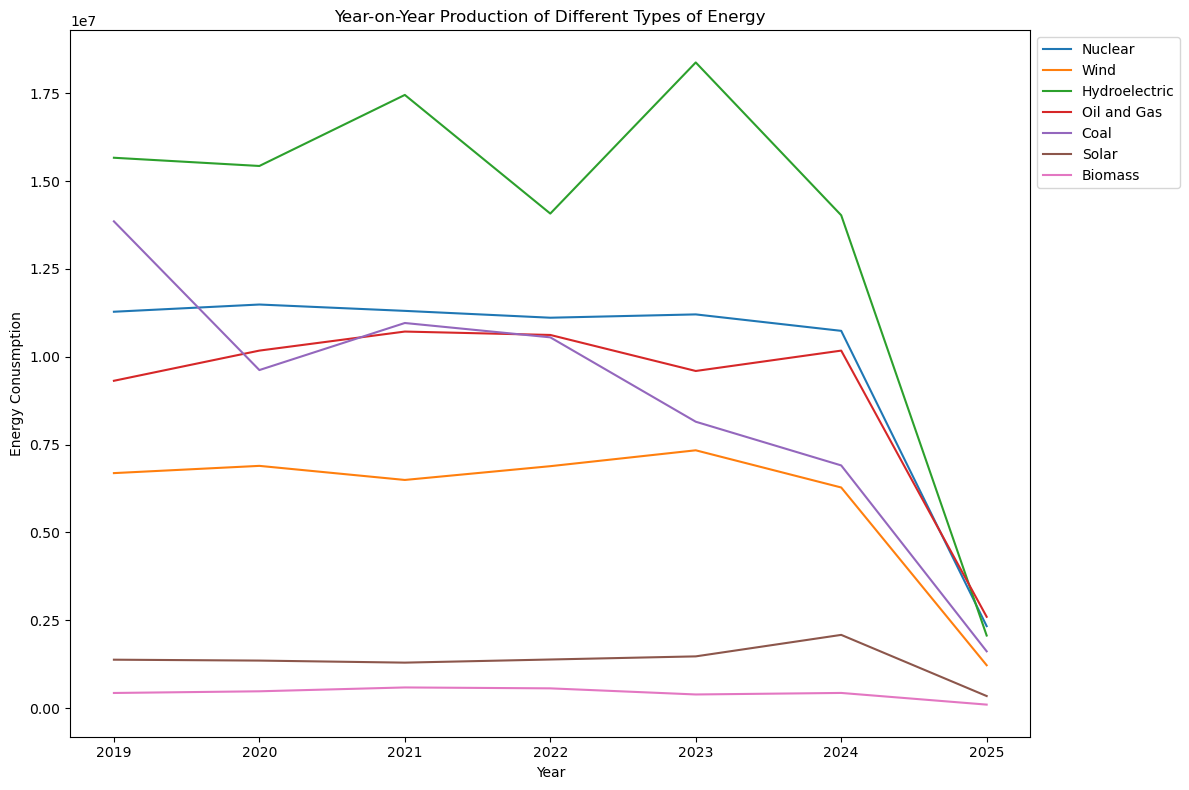

In [14]:
# Plot Year-on-Year Production of Different Types of Energy
energy_types = ['Nuclear','Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']

mtlplt.figure(figsize=(12, 8))
for energy_type in energy_types:
    mtlplt.plot(df_grouped_year['Year'], df_grouped_year[energy_type], label=energy_type)

mtlplt.xlabel('Year')
mtlplt.ylabel('Energy Conusmption')
mtlplt.title('Year-on-Year Production of Different Types of Energy')
mtlplt.legend(loc='upper left', bbox_to_anchor=(1, 1))

mtlplt.tight_layout()
mtlplt.show()

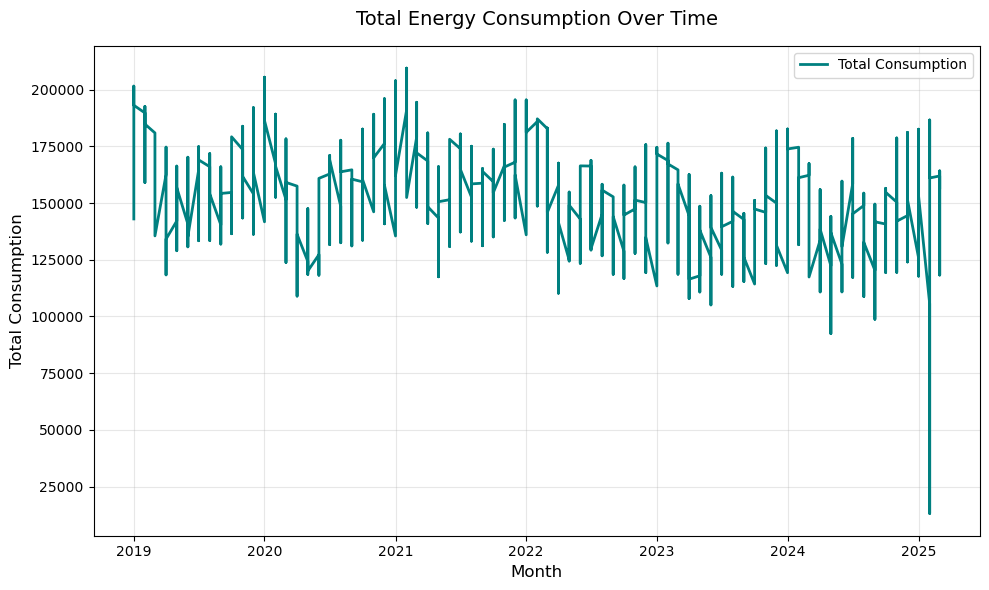

In [15]:
# Create a 'Month' column (only year-month part)
daily_df["Month"] = daily_df["DateTime"].dt.to_period("M").dt.to_timestamp()
# Set Month as index
daily_df.set_index("Month", inplace=True)

# Plot the total energy consumption over time
mtlplt.figure(figsize=(10, 6))
mtlplt.plot(daily_df.index, daily_df["Consumption"], color="teal", linewidth=2, label="Total Consumption")
mtlplt.title("Total Energy Consumption Over Time", fontsize=14, pad=15)
mtlplt.xlabel("Month", fontsize=12)
mtlplt.ylabel("Total Consumption", fontsize=12)
mtlplt.grid(alpha=0.3)
mtlplt.legend()
mtlplt.tight_layout()
mtlplt.show()

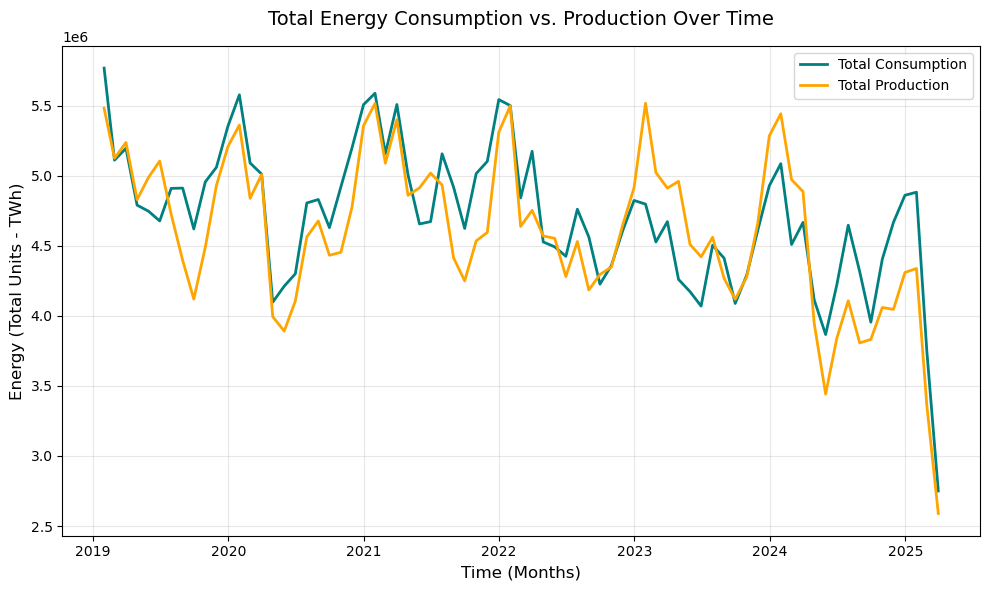

In [16]:
# If your data is daily, resample to monthly (optional for smoother plot)
monthly_df = daily_df.resample("M", on="DateTime")[["Consumption", "Production"]].sum()

# Plot both Consumption and Production over time
mtlplt.figure(figsize=(10, 6))
mtlplt.plot(monthly_df.index, monthly_df["Consumption"], color="teal", linewidth=2, label="Total Consumption")
mtlplt.plot(monthly_df.index, monthly_df["Production"], color="orange", linewidth=2, label="Total Production")

# Add titles and labels
mtlplt.title("Total Energy Consumption vs. Production Over Time", fontsize=14, pad=15)
mtlplt.xlabel("Time (Months)", fontsize=12)
mtlplt.ylabel("Energy (Total Units - TWh)", fontsize=12)
mtlplt.grid(alpha=0.3)
mtlplt.legend()
mtlplt.tight_layout()
mtlplt.show()

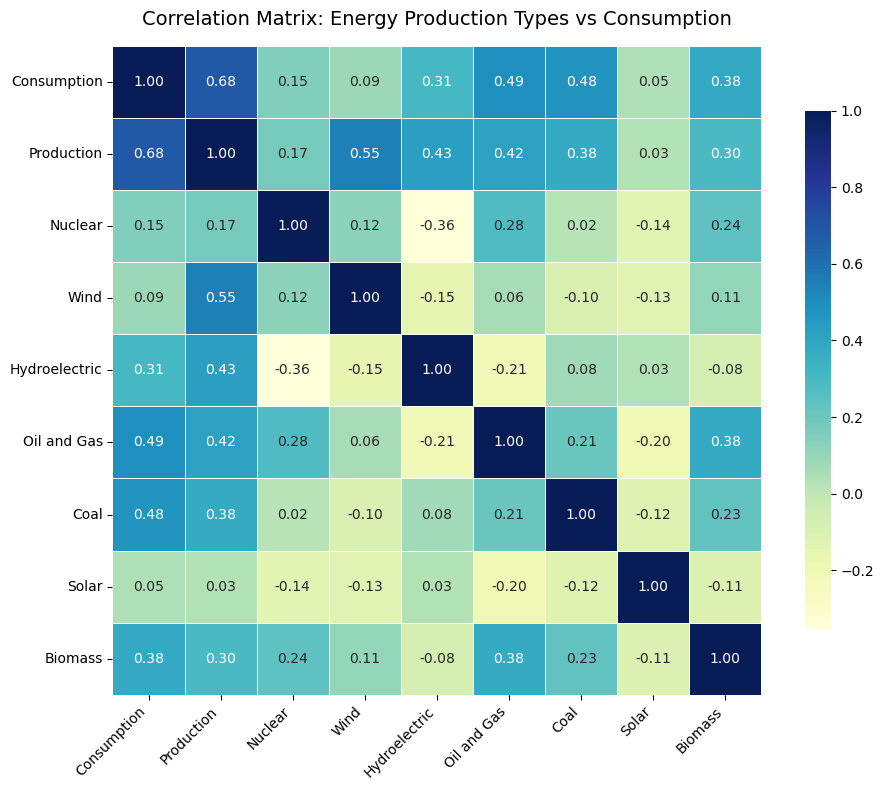

In [17]:
# Select relevant numeric columns
energy_cols = [
    "Consumption", "Production", "Nuclear", "Wind",
    "Hydroelectric", "Oil and Gas", "Coal", "Solar", "Biomass"
]

# Keep only these columns
df_energy = data_frame[energy_cols].copy()

# Compute the correlation matrix
corr_matrix = df_energy.corr(method="pearson")


mtlplt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5,
    square=True,
    cbar_kws={"shrink": 0.8}
)
mtlplt.title("Correlation Matrix: Energy Production Types vs Consumption", fontsize=14, pad=15)
mtlplt.xticks(rotation=45, ha="right")
mtlplt.yticks(rotation=0)
mtlplt.tight_layout()
mtlplt.show()

In [18]:
corr_matrix

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
Consumption,1.000000,0.681003,0.147747,0.088225,0.307053,0.494118,0.475399,0.045189,0.382624
Production,0.681003,1.000000,0.173896,0.547370,0.426415,0.418187,0.380018,0.030743,0.300670
Nuclear,0.147747,0.173896,1.000000,0.121337,-0.356007,0.280926,0.021643,-0.137071,0.241170
Wind,0.088225,0.547370,0.121337,1.000000,-0.150315,0.061389,-0.098233,-0.131456,0.110086
Hydroelectric,0.307053,0.426415,-0.356007,-0.150315,1.000000,-0.211116,0.076164,0.033727,-0.077416
Oil and Gas,0.494118,0.418187,0.280926,0.061389,-0.211116,1.000000,0.213912,-0.201225,0.378793
Coal,0.475399,0.380018,0.021643,-0.098233,0.076164,0.213912,1.000000,-0.120251,0.234490
Solar,0.045189,0.030743,-0.137071,-0.131456,0.033727,-0.201225,-0.120251,1.000000,-0.112378
Biomass,0.382624,0.300670,0.241170,0.110086,-0.077416,0.378793,0.234490,-0.112378,1.000000


In [19]:
result = adfuller(daily_df.filter(['Consumption']).dropna())

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] < 0.05:
    print("The series is stationary")
else:
    print("The series is non-stationary")

ADF Statistic: -3.25027989383556
p-value: 0.01725261880858365
Critical Values: {'1%': -3.433272682848605, '5%': -2.86283115989218, '10%': -2.567457345543686}
The series is stationary


In [32]:
DATE_COL = None        # e.g., "DateTime" or "Day"
DATE_FORMAT = "%d/%m/%Y"  # set for your data like 13/01/2019
DAYFIRST = True
TARGET_COL = "Consumption"
VAL_FRACTION = 0.2
RANDOM_STATE = 42
N_ESTIMATORS = 300

In [37]:
# ========= Lag & Rolling Features =========
data_frame[f"{TARGET_COL}_lag1"]  = data_frame[TARGET_COL].shift(1)
data_frame[f"{TARGET_COL}_lag7"]  = data_frame[TARGET_COL].shift(7)
data_frame[f"{TARGET_COL}_lag30"] = data_frame[TARGET_COL].shift(30)
data_frame[f"{TARGET_COL}_roll7"]  = data_frame[TARGET_COL].rolling(7).mean()
data_frame[f"{TARGET_COL}_roll30"] = data_frame[TARGET_COL].rolling(30).mean()

# Optional driver lags
for col in ["Production", "Nuclear", "Wind", "Hydroelectric", "Oil and Gas", "Coal", "Solar", "Biomass"]:
    if col in data_frame.columns:
        data_frame[f"{col}_lag1"] = data_frame[col].shift(1)

data_frame = data_frame.dropna().reset_index(drop=True)

numeric_cols = data_frame.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != TARGET_COL]

print("n_features after lags/rollings:", len(feature_cols))
print("Sample features:", feature_cols[:15])

n_features after lags/rollings: 21
Sample features: ['Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'Consumption_lag1', 'Consumption_lag7', 'Consumption_lag30', 'Consumption_roll7', 'Consumption_roll30', 'Production_lag1', 'Nuclear_lag1']


In [38]:
# ========= Chronological Train/Validation Split =========
split_idx = int(len(data_frame) * (1 - VAL_FRACTION))
train = data_frame.iloc[:split_idx].copy()
valid = data_frame.iloc[split_idx:].copy()

X_train = train[feature_cols].values
y_train = train[TARGET_COL].values

X_valid = valid[feature_cols].values
y_valid = valid[TARGET_COL].values

print("Train size:", X_train.shape, " Valid size:", X_valid.shape)

Train size: (43312, 21)  Valid size: (10828, 21)


In [39]:
try:
    from xgboost import XGBRegressor
    model = XGBRegressor(
        n_estimators=600, learning_rate=0.05, max_depth=6,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, n_jobs=-1
    )
   
except Exception as _:
    print("XGBoost not available; skipping.")

metrics_table = []

def evaluate(y_true, y_pred):
    # rmse = np.sqrt(np.mean(((predictions- Ytest)**2)))
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

model.fit(X_train, y_train)
pred_val = model.predict(X_valid)
rmse, mae, r2 = evaluate(y_valid, pred_val)

metrics_table.append([rmse, mae, r2])
metrics_df = pd.DataFrame(columns=["RMSE", "MAE", "R2"]).sort_values("RMSE")
metrics_df



,RMSE,MAE,R2


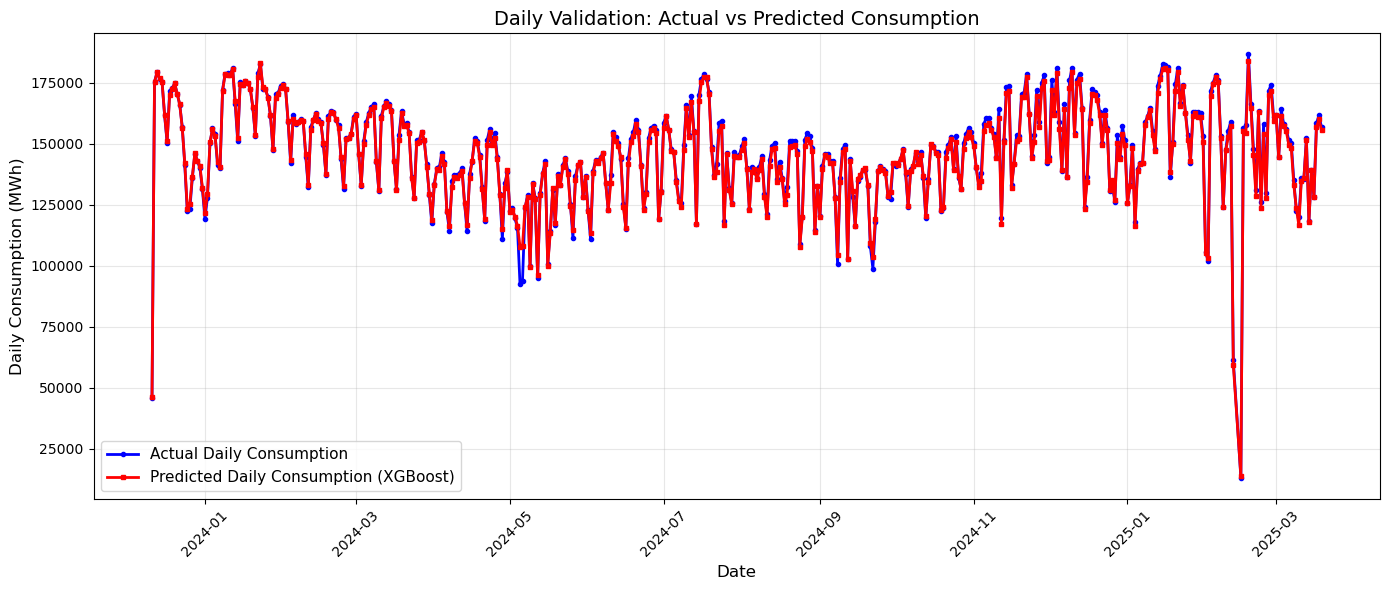

In [40]:

# Generate XGBoost predictions (re-create the model to ensure we have the right one)
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, n_jobs=-1
)
xgb_model.fit(X_train, y_train)
valid_pred = xgb_model.predict(X_valid)

# Create a DataFrame with actual and predicted values for daily aggregation
validation_results = pd.DataFrame({
    'DateTime': valid['DateTime'],
    'Actual': y_valid,
    'Predicted': valid_pred
})

# Convert DateTime to proper datetime format and aggregate to daily level
validation_results['DateTime'] = pd.to_datetime(validation_results['DateTime'])
daily_validation = validation_results.groupby(validation_results['DateTime'].dt.date).agg({
    'Actual': 'sum',
    'Predicted': 'sum'
}).reset_index()

# Convert the date back to datetime for plotting
daily_validation['DateTime'] = pd.to_datetime(daily_validation['DateTime'])

# Create daily visualization
mtlplt.figure(figsize=(14, 6))
mtlplt.plot(daily_validation['DateTime'], daily_validation['Actual'], 
           label="Actual Daily Consumption", linewidth=2, color='blue', marker='o', markersize=3)
mtlplt.plot(daily_validation['DateTime'], daily_validation['Predicted'], 
           label="Predicted Daily Consumption (XGBoost)", linewidth=2, color='red', marker='s', markersize=3)

mtlplt.title("Daily Validation: Actual vs Predicted Consumption", fontsize=14)
mtlplt.xlabel("Date", fontsize=12)
mtlplt.ylabel("Daily Consumption (MWh)", fontsize=12)
mtlplt.legend(fontsize=11)
mtlplt.grid(True, alpha=0.3)
mtlplt.xticks(rotation=45)
mtlplt.tight_layout()
mtlplt.show()

# Calculate metrics on daily aggregated data
daily_rmse = mean_squared_error(daily_validation['Actual'], daily_validation['Predicted'], squared=False)
daily_mae = mean_absolute_error(daily_validation['Actual'], daily_validation['Predicted'])
daily_r2 = r2_score(daily_validation['Actual'], daily_validation['Predicted'])

# Also calculate metrics on original hourly data for comparison
hourly_rmse = mean_squared_error(y_valid, valid_pred, squared=False)
hourly_mae = mean_absolute_error(y_valid, valid_pred)
hourly_r2 = r2_score(y_valid, valid_pred)



In [41]:
print(f"XGBoost Model Performance:")
print(f"{'='*50}")
print(f"   DAILY AGGREGATED METRICS:")
print(f"   RMSE: {daily_rmse:.2f} MWh")
print(f"   MAE : {daily_mae:.2f} MWh")
print(f"   R²  : {daily_r2:.4f} \n")
print(f"   HOURLY METRICS (for reference):")
print(f"   RMSE: {hourly_rmse:.2f} MWh")
print(f"   MAE : {hourly_mae:.2f} MWh")
print(f"   R²  : {hourly_r2:.4f} \n")
print(f"   Daily aggregated data shown in the plot above")
print(f"   Total validation days: {len(daily_validation)}")

XGBoost Model Performance:
   DAILY AGGREGATED METRICS:
   RMSE: 1690.78 MWh
   MAE : 1140.36 MWh
   R²  : 0.9930 

   HOURLY METRICS (for reference):
   RMSE: 201.20 MWh
   MAE : 141.57 MWh
   R²  : 0.9602 

   Daily aggregated data shown in the plot above
   Total validation days: 463


📈 DETAILED DAILY COMPARISON - RECENT 60 DAYS


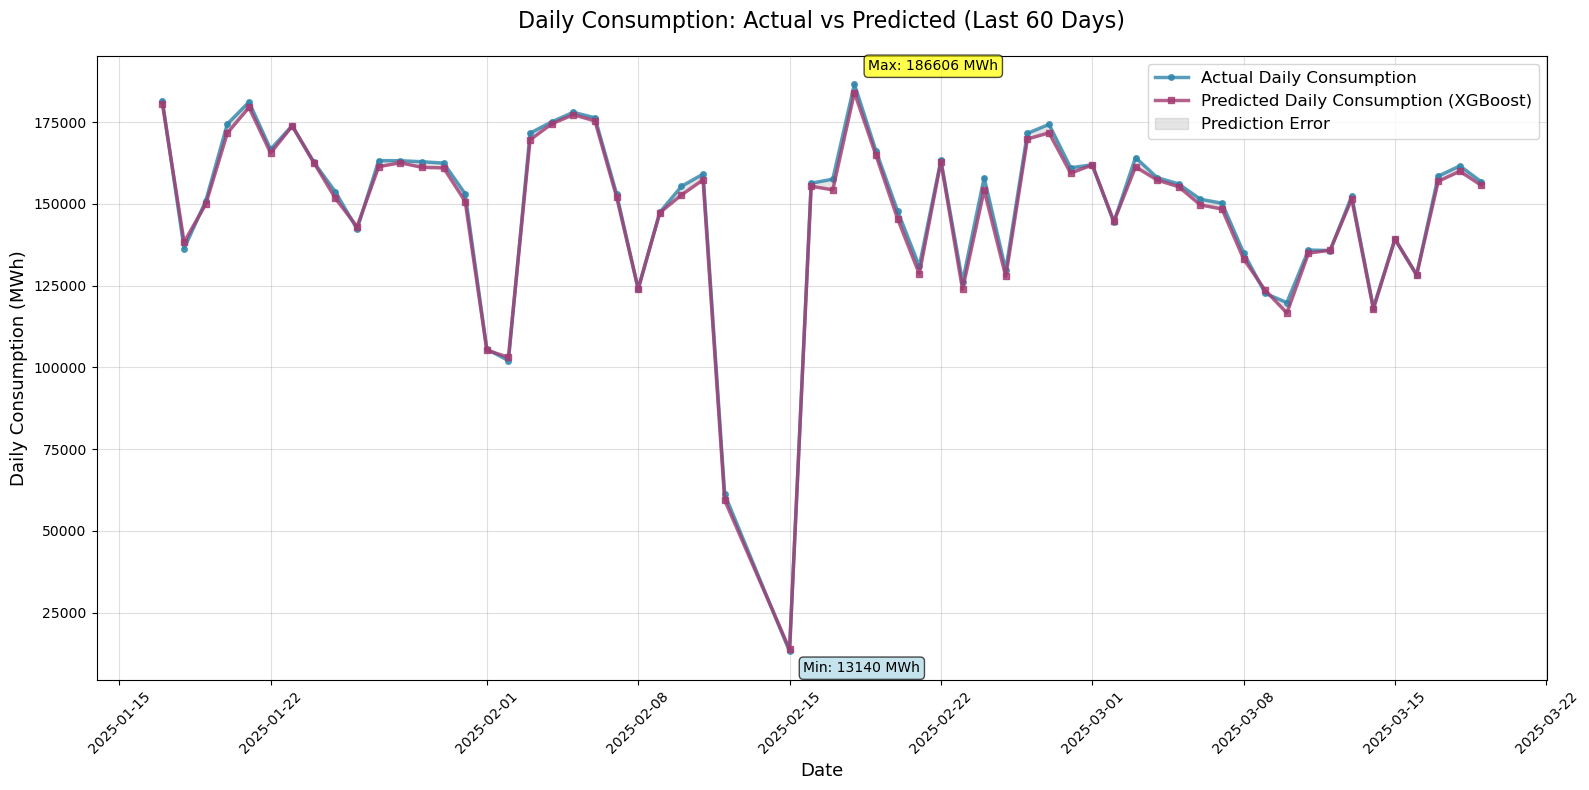


📊 RECENT 60 DAYS STATISTICS:
Average Daily Actual: 148822 MWh
Average Daily Predicted: 147643 MWh
Average Daily Error: -1179 MWh
Average Absolute Error: 1369 MWh
Average Percentage Error: -0.7%
Max Daily Error: 1979 MWh
Min Daily Error: -3807 MWh

🔍 DAYS WITH LARGEST PREDICTION ERRORS:
  2025-02-24: Actual=157997, Predicted=154190, Error=-3807 MWh
  2025-02-17: Actual=157554, Predicted=154268, Error=-3286 MWh
  2025-03-10: Actual=119808, Predicted=116608, Error=-3200 MWh
  2025-03-03: Actual=164164, Predicted=161296, Error=-2868 MWh
  2025-01-20: Actual=174416, Predicted=171655, Error=-2761 MWh


In [42]:
# Create a more detailed view of daily actual vs predicted for recent period
print("📈 DETAILED DAILY COMPARISON - RECENT 60 DAYS")
print("="*55)

# Get the last 60 days for detailed view
recent_daily = daily_validation.tail(60).copy()

# Create detailed daily plot
mtlplt.figure(figsize=(16, 8))

# Plot with different styles for better distinction
mtlplt.plot(recent_daily['DateTime'], recent_daily['Actual'], 
           label="Actual Daily Consumption", linewidth=2.5, color='#2E86AB', 
           marker='o', markersize=4, alpha=0.8)
mtlplt.plot(recent_daily['DateTime'], recent_daily['Predicted'], 
           label="Predicted Daily Consumption (XGBoost)", linewidth=2.5, color='#A23B72', 
           marker='s', markersize=4, alpha=0.8)

# Fill between to show the difference
mtlplt.fill_between(recent_daily['DateTime'], 
                   recent_daily['Actual'], 
                   recent_daily['Predicted'], 
                   alpha=0.2, color='gray', label='Prediction Error')

mtlplt.title("Daily Consumption: Actual vs Predicted (Last 60 Days)", fontsize=16, pad=20)
mtlplt.xlabel("Date", fontsize=13)
mtlplt.ylabel("Daily Consumption (MWh)", fontsize=13)
mtlplt.legend(fontsize=12, loc='upper right')
mtlplt.grid(True, alpha=0.4)
mtlplt.xticks(rotation=45)

# Add annotations for max and min points
max_actual_idx = recent_daily['Actual'].idxmax()
min_actual_idx = recent_daily['Actual'].idxmin()

max_actual_date = recent_daily.loc[max_actual_idx, 'DateTime']
max_actual_value = recent_daily.loc[max_actual_idx, 'Actual']
min_actual_date = recent_daily.loc[min_actual_idx, 'DateTime']
min_actual_value = recent_daily.loc[min_actual_idx, 'Actual']

mtlplt.annotate(f'Max: {max_actual_value:.0f} MWh', 
               xy=(max_actual_date, max_actual_value), 
               xytext=(10, 10), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
               fontsize=10)

mtlplt.annotate(f'Min: {min_actual_value:.0f} MWh', 
               xy=(min_actual_date, min_actual_value), 
               xytext=(10, -15), textcoords='offset points',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7),
               fontsize=10)

mtlplt.tight_layout()
mtlplt.show()

# Calculate and display daily statistics
daily_error = recent_daily['Predicted'] - recent_daily['Actual']
daily_abs_error = abs(daily_error)
daily_percent_error = (daily_error / recent_daily['Actual']) * 100

print(f"\n📊 RECENT 60 DAYS STATISTICS:")
print(f"Average Daily Actual: {recent_daily['Actual'].mean():.0f} MWh")
print(f"Average Daily Predicted: {recent_daily['Predicted'].mean():.0f} MWh")
print(f"Average Daily Error: {daily_error.mean():.0f} MWh")
print(f"Average Absolute Error: {daily_abs_error.mean():.0f} MWh")
print(f"Average Percentage Error: {daily_percent_error.mean():.1f}%")
print(f"Max Daily Error: {daily_error.max():.0f} MWh")
print(f"Min Daily Error: {daily_error.min():.0f} MWh")

# Show days with largest prediction errors
print(f"\n🔍 DAYS WITH LARGEST PREDICTION ERRORS:")
error_analysis = recent_daily.copy()
error_analysis['Error'] = daily_error
error_analysis['Abs_Error'] = daily_abs_error
error_analysis['Date_Str'] = error_analysis['DateTime'].dt.strftime('%Y-%m-%d')

worst_predictions = error_analysis.nlargest(5, 'Abs_Error')[['Date_Str', 'Actual', 'Predicted', 'Error']]
for idx, row in worst_predictions.iterrows():
    print(f"  {row['Date_Str']}: Actual={row['Actual']:.0f}, Predicted={row['Predicted']:.0f}, Error={row['Error']:.0f} MWh")